# 1.数据预处理


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
#导入数据，查看数据基本情况
listings=pd.read_csv('D:/F/jupyter\listings.csv')


In [3]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,NaN,朝阳区 / Chaoyang,39.89503,116.45163,Entire home/apt,792,1,89,2019-03-04,0.85,9,341
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,NaN,密云县 / Miyun,40.68434,117.17231,Private room,1201,1,2,2017-10-08,0.10,4,0
2,128496,Heart of Beijing: House with View 2,467520,Cindy,NaN,东城区,39.93213,116.42200,Entire home/apt,389,3,259,2019-02-05,2.70,1,93
3,161902,cozy studio in center of Beijing,707535,Robert,NaN,东城区,39.93357,116.43577,Entire home/apt,376,1,26,2016-12-03,0.28,5,290
4,162144,"nice studio near subway, sleep 4",707535,Robert,NaN,朝阳区 / Chaoyang,39.93668,116.43798,Entire home/apt,537,1,37,2018-08-01,0.40,5,352


In [4]:
#数据清洗
#neighbourhood_group全为空值没有意义，可删除该列
listings=listings.drop(['neighbourhood_group'],axis=1)

In [5]:
#删掉'name'列缺失值所在行
listings = listings[listings['name'].notnull()]

In [6]:
#'neighbourhood'列只要前面的中文字
listings['neighbourhood'] = listings['neighbourhood'].str.split('/').str[0].str.strip()

In [7]:
# 查看房屋类型有多少种
#房屋类型有三种，分别是Entire home/apt，Private room，Shared room
listings['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [8]:
#由于只有3条数据，其中除了测试房源外的两个房源都不应该为0，直接删除
listings = listings[listings['price']!=0]

In [9]:
#删除价格在50000以上的整租房源，在20000以上的独立房源，在10000以上的合租房源
listings.drop(listings[(listings['room_type']=='Entire home/apt') & (listings['price']>50000)].index,inplace=True)
listings.drop(listings[(listings['room_type']=='Private room') & (listings['price']>20000)].index,inplace=True)
listings.drop(listings[(listings['room_type']=='Shared room') & (listings['price']>10000)].index,inplace=True)

In [10]:
# 删除最短居住日期在600以上的数据
listings = listings[listings['minimum_nights']<600]

# 2.房源推荐


## 2.1 数据预处理

### 对不同房源的评价进行情感分析，并将评分保存至reviews_processed.csv文件中。首先对文件中的数据进行预处理

In [11]:
#处理评论评分
df = pd.read_csv("D:\F\jupyter/reviews_processed.csv")
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,positive_prob
0,44054.0,84748.0,2010-08-25,207019.0,Jarrod,Sev was very helpful. Sev showed us where to ...,0.9585309999999999
1,44054.0,118384.0,2010-10-13,218723.0,Kimberly,We arrived in Beijing very early in the mornin...,0.919216
2,44054.0,436978.0,2011-08-11,609177.0,Emma,It is a really massive apartment and really co...,0.994668
3,44054.0,1118657.0,2012-04-12,1787536.0,Andreyna,"Sev was incredibly helpful, showed us around t...",0.99146
4,44054.0,2140650.0,2012-08-30,1179565.0,Frances,The appartment was ideal for our party of 6 ad...,0.9801549999999999


In [12]:
#数据预处理
df = df[df['positive_prob'].notnull()]
df_isnum=df['positive_prob'].str.len()
df=df[df_isnum<=8]
df=df[df_isnum>=7]
df.head()

<ipython-input-12-3e02a348e006>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[df_isnum>=7]


,listing_id,id,date,reviewer_id,reviewer_name,comments,positive_prob
1,44054.0,118384.0,2010-10-13,218723.0,Kimberly,We arrived in Beijing very early in the mornin...,0.919216
2,44054.0,436978.0,2011-08-11,609177.0,Emma,It is a really massive apartment and really co...,0.994668
3,44054.0,1118657.0,2012-04-12,1787536.0,Andreyna,"Sev was incredibly helpful, showed us around t...",0.99146
6,44054.0,2507676.0,2012-10-04,3659992.0,Patrick,We had a great experience in Beijing. The apa...,0.986246
7,44054.0,2886867.0,2012-11-15,3725353.0,Zahra,The apartment was exactly what I expected (as ...,0.995725


In [13]:
#将评分转换为float属性，方便求每个短租房的平均评分
df['positive_prob']=df['positive_prob'].astype(float)
df.dtypes

listing_id       float64
id               float64
date              object
reviewer_id      float64
reviewer_name     object
comments          object
positive_prob    float64
dtype: object

### 由于每个房源有很多评论，为每个房源的评价求一个平均分，并按照降序的方式对评分进行排序

In [14]:
#求每个短租房的平均评分,并将其保存至新的
grouped2=df.groupby('listing_id',as_index=False)['positive_prob']
group=grouped2.aggregate(np.mean)
data=pd.DataFrame(group)
data=data.sort_values(by="positive_prob" , ascending=False)



In [15]:
data = pd.read_csv("D:\F\jupyter/result1.csv",index_col=0)
data

,listing_id,positive_prob
id,,
1,27444031,0.999994
2,33388753,0.999994
3,27742321,0.999994
4,32756739,0.999994
5,23248168,0.999994
...,...,...
15713,30929417,0.105618
15714,17312215,0.091238
15715,22964206,0.012775


### 对前10位优质房源进行探索性分析

In [16]:
listings.to_csv('list.csv',index=None)
listing = pd.read_csv("D:\F\jupyter/list.csv")


In [17]:
nid=[]
building=pd.read_csv('D:\F\jupyter\\buildings.csv')
for i in range(1,10):
    nid.append(data.loc[i,'listing_id'])


#### 将优质房源信息保存在building.csv中

In [21]:
x=0
for i in nid:
    for j in range (0,28427):
        if i==listing.loc[j,'id']:
            building.loc[x]=listing.loc[j]
            x=x+1
building.to_csv('buildings.csv', mode='a', header=False)


In [22]:
building

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,27444031,故宫东华门/王府井步行5分钟/近协和医院､妇产医院/典雅两人间,199608290,园,东城区,39.91620,116.40795,Entire home/apt,503.0,1,3,2019-02-21,0.39,27,136
1,33388753,CBD三里屯团结湖朝阳公园带阳台朝南蓝色大床大主卧,20953146,Frank,朝阳区,39.93431,116.46813,Private room,248.0,1,1,2019-04-07,1.00,1,362
2,27742321,『新年特惠』【品酒师之家】魏公村地铁站 | 动物园| 北理工 | 圆明园 |舒适两居室可做饭,175796487,莹莹,海淀区,39.96113,116.31929,Entire home/apt,362.0,1,1,2018-12-20,0.25,5,365
3,32756739,【蜗居】一个人的独处不如两个人的相依,220495764,Jason,朝阳区,39.90181,116.60125,Entire home/apt,1000.0,1,2,2019-03-17,1.50,1,316
4,23248168,近故宫带吧台的四合院,94320778,Joanna,东城区,39.91283,116.40453,Private room,1798.0,3,2,2019-03-21,0.14,10,67
5,26368341,北京怀柔泡桐小院1号院,198114561,添,怀柔区,40.37764,116.43312,Entire home/apt,1597.0,1,2,2018-09-04,0.23,2,361
6,16453093,芍药居机场线地铁鸟巢水立方南锣鼓巷附近深入骨髓的迷你美式LOFT出租,106955956,辉,朝阳区,39.97619,116.43141,Private room,497.0,1,2,2019-01-06,0.09,3,355
7,33218053,四季青桥五棵松桥高档小区豪华大床商务套间芳菲苑,250101730,希健,海淀区,39.93866,116.27284,Private room,429.0,1,2,2019-04-07,2.00,2,150
8,33458510,萤火虫5分钟到地铁站直达西站丰台科技园紧邻良乡大学城,251866931,宝丽,房山区,39.76381,116.18200,Entire home/apt,577.0,1,2,2019-04-13,2.00,1,163


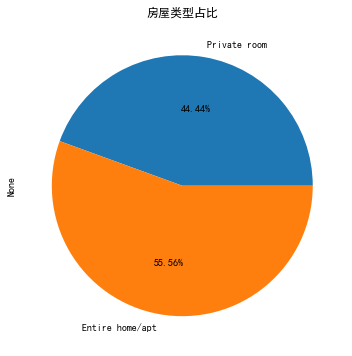

In [23]:
build = building.groupby(['neighbourhood','room_type']).agg({'id':'size','price':'mean'})
build = build.rename(columns={'id':'number'})
data_1 = build.unstack()['number']
data_2 = data_1.sum(0).sort_values()
plt.title('房屋类型占比')
data_2.plot.pie(figsize=(6,6),autopct='%.2f%%')

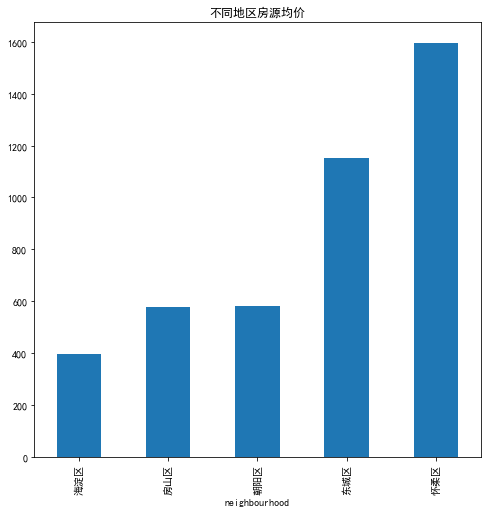

In [24]:

building.groupby('neighbourhood')['price'].mean().sort_values().plot.bar(figsize=(8,8),title='不同地区房源均价')

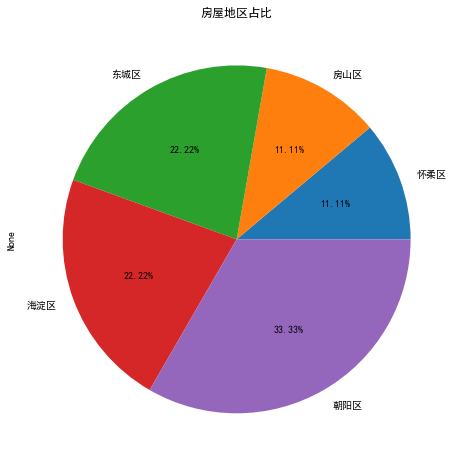

In [25]:
data_3 = data_1.sum(1).sort_values()
plt.title('房屋地区占比')
data_3.plot.pie(figsize=(8,8),autopct='%.2f%%')

## 2.2 为用户推荐房源

### 由用户输入想要选择的地点、房间类型和价格区间，在满足这些条件的基础上，我们为用户推荐10套评价最高的房源供用户挑选

In [27]:
#接收用户筛选请求
neighbourhood = input("请输入需要选择的房源位置（例如 东城区）：\n")
room_type = input("请输入租房类型（Entire home/apt，Private room，Shared room）：\n")
print("请输入您可以接受的价格区间")
price_min = input("请输入房价的下限：\n")
price_max =input("请输入房价的上限：\n")


请输入需要选择的房源位置（例如 东城区）：
东城区
请输入租房类型（Entire home/apt，Private room，Shared room）：
Private room
请输入您可以接受的价格区间
请输入房价的下限：
50
请输入房价的上限：
500


In [30]:
price_min=float(price_min)
price_max=float(price_max)

In [31]:
listings.to_csv('list.csv',index=None)
listing = pd.read_csv("D:\F\jupyter/list.csv")
listing.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [32]:
#求出符合条件的房源id
n=[]
for i in range(0,28427):
    if listing.loc[i,'neighbourhood']==neighbourhood :
        if listing.loc[i,'room_type']==room_type :
            if listing.loc[i,'price']>=price_min  and listing.loc[i,'price']<= price_max:
                n.append(listing.loc[i,'id'])


In [33]:
if len(n)==0:
    print("没有符合条件的房源")
else: 
    m=[]
    y=0
    for i in range(0,len(n)-1):
        for j in range(1,15717):
            if n[i]==data.loc[j,'listing_id']:
                m.append(n[i])
                y=y+1
                if y==10:
                    break
        if y==10:
                    break
            

### 最终向用户推荐以下十个房源，为了清晰明了，推荐结果中只包含了房源id，房子名称以及价格

In [34]:
print("向您推荐评价最好的十个房源：\n")
columns=['id','name','price']
for i in range(0,28451):
    for j in range(0,9):
        if listing.loc[i,'id']==m[j]:
            print(listing.iloc[i][columns].values)

向您推荐评价最好的十个房源：

[829407 'Gladys Garden - casual living' 289.0]
[851984 'Gladys Garden - casual living 2' 262.0]
[855090 'Gladys Garden - casual living 3' 242.0]
[975146 'Cozy Courtyard w/ Private Bathroom!' 490.0]
[1165040 '[Newyard PROMOTION]Former residence of Mei Lanfang' 134.0]
[1543047 'Gladys Garden - casual living 4' 282.0]
[1787002 'Cozy local style room in hutong center of Beijing' 201.0]
[5741741 'Superb bedroom at Dongzhimen' 201.0]
[6034500 'BJ hutong lifestyle' 470.0]
